# Tutorial of Analyzing National Suicide Rate with GDP per Capita

* Chenqian Lin
* Kaian Sitou

### Introduction

This tutorial will introduce you to some basic method we had learned in class in order to process the global deaths data, our analysis especially focusing on the suicide data, which significantly demonstrated a complex issue around the world. We are using this data to analyze how a nation's economy will affect its suicide rate. We also added some graphs, map or plots to show you a better visualization and understandable analysis. 

### Tutorial content

In this tutorial, we will analyze on multiple dataset using Python, with linear model from [Scikit-learn](http://scikit-learn.org), F-test from [StatsModels](http://www.statsmodels.org/), and some feature from [SciPy](https://www.scipy.org) and [Folium](https://github.com/python-visualization/folium).

We will use data from the following website:

* Global deaths and population data: [WHO Mortality Database](http://www.who.int/healthinfo/statistics/mortality_rawdata/en/)
* Global population data: [World Bank Data - Population, total](http://data.worldbank.org/indicator/SP.POP.TOTL)
* Global GDP per capita data: [World Bank Data - GDP per capita (USD)](data.worldbank.org/indicator/NY.GDP.PCAP.CD)

### Table of  Content:
* [Importing libraries](#lib)
* [Importing datasets](#main_data)
* [Combine tables](#combine)
* [Standardize variables](#std_var)
* [Fitting & testing a Linear Regression Modle](#fit)
* [Analyze using map](#map)
* [Anylyze using correlation coefficient](#r)

### Importing Libraries <a class="anchor" id="lib"></a>

To start our tutorial, we need to first import libraries we'll be using

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import folium
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats.stats import pearsonr

### Importing Data <a class="anchor" id="main_data"></a>

After loading the libraries, let's get our global deaths dataset. WHO(World Health Organization) split the data into two parts due to the size of the data. 

First downloading the two "Mortality, ICD-10" zip files from WHO, then go ahead and unzip them. We load "Morticd10_part1" and "Morticd10_part2" with pandas and use concat method to combine the two parts into a single DataFrame. 

In [2]:
data_raw_p1 = pd.read_csv("Morticd10_part1", low_memory=False)
data_raw_p2 = pd.read_csv("Morticd10_part2", low_memory=False)
data_raw = pd.concat([data_raw_p1, data_raw_p2])
data_raw.head()

,Country,Admin1,SubDiv,Year,List,Cause,Sex,Frmat,IM_Frmat,Deaths1,...,Deaths21,Deaths22,Deaths23,Deaths24,Deaths25,Deaths26,IM_Deaths1,IM_Deaths2,IM_Deaths3,IM_Deaths4
0,1400,NaN,NaN,2001,101,1000,1,7,8,332,...,95.0,NaN,NaN,NaN,NaN,0.0,8.0,NaN,NaN,NaN
1,1400,NaN,NaN,2001,101,1000,2,7,8,222,...,112.0,NaN,NaN,NaN,NaN,0.0,11.0,NaN,NaN,NaN
2,1400,NaN,NaN,2001,101,1001,1,7,8,24,...,5.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
3,1400,NaN,NaN,2001,101,1001,2,7,8,14,...,6.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
4,1400,NaN,NaN,2001,101,1002,1,7,8,0,...,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN


The table contains many aspects, but we are only interested in a few of them:
* Country - Code represents a country (see file "Country_codes.zip")
* Year - Year to which data refer
* Cause - Cause of death (represented by code)
* Deaths1 - Deaths at all ages

Also, since we are only interested in suicide data, we need to filter out other cause. In the table, suicide is represented with code 1101 or X60 to X84.

In [3]:
suicide_data_list = []
for cause_code, group in data_raw.groupby('Cause'):
    if cause_code == '1101' or (cause_code[0] == 'X' and 60 <= int(cause_code[1:3]) <= 84):
        suicide_data_list += [group]
suicide_data = pd.concat(suicide_data_list)

At this point, we would like to import other dataset we need: population, country code, and GDP per capita(PPP). Note that there are two datasets for population, we are doing this because there are missing values in each of them, but with both, we have a more complete population data. 

In [4]:
# population dataset from WHO
populations_raw = pd.read_csv("pop")
# population dataset from World Bank Data
populations_tbl2 = pd.read_csv("API_SP.POP.TOTL_DS2_en_csv_v2.csv", index_col = 1)
# country code reference table (e.g. 2450, United States of America)
country_codes = pd.read_csv("country_codes", index_col = 0)
# country name to ISO-3 code table (e.g. Japan, JAP)
# because datasets from different websites might use different names for same country, 
# we would like to use ISO-3 to match them
country_ISO_code = pd.read_csv("Country_ISO_codes.csv", index_col = 0)
# GDP per capita
ppp_table = pd.read_csv("API_NY.GDP.PCAP.CD_DS2_en_csv_v2.csv", index_col = 1)

To make these dataset easier to access, we cut down the collumns of population table, and transform country code tables to dictionaries. 

In [5]:
populations = populations_raw.groupby(['Country', "Year"])['Pop1'].sum()
country_name_dict = country_codes['name'].to_dict()
country_name2iso = pd.read_csv("Country_ISO_codes.csv", index_col = 0)['ISO'].to_dict()

### Combine Datasets <a class="anchor" id="combine"></a>

Now we have all datasets needed for the analysis, it is time to combine them and create a table with all attributes we want.

The following code defines a function that estimate the total population of a given country in a specific year. This function will be used when we forming the table. It first look at the dataset provided by WHO, if there is no good match found, then search it in the other dataset from World Bank Data. 

In [6]:
def est_pop(country, country_iso_code, year):
    if country in populations.index.levels[0]:
        # look for population data from the WHO's dataset
        if (country, year) in populations.index:
            return populations[(country, year)]
        else:
            # estimate the populations from the previous and following years
            pre = nxt = None
            for y in populations[country].index:
                if y < year:
                    pre = y
                else:
                    nxt = y
                    break
            if pre is None or nxt is None:
                return populations[(country, pre or nxt)]
            pre_pop = populations[(country, pre)]
            nxt_pop = populations[(country, nxt)]
            return (nxt_pop - pre_pop) / (nxt - pre) * (year - pre) + pre_pop
    elif country_iso_code in populations_tbl2.index:
        # search data in the World Bank's dataset
        pop = populations_tbl2[str(year)][country_iso_code]
        return pop or np.nan
    else:
        return np.nan

The following code forms a table that's easier to read, with country, year, number of suicides, total population, suicide rate, and GDP per capita as its columns. We pick out the deaths column of suicide from the deaths count table and add up the number for both genders. We add country name and ISO-3 code to each datapoint. Then get Total population and GDP per capita values from the other two tables. And finally calculate the suicide rates by dividing the number of suicides with total population.   

In [131]:
suicide_count = suicide_data.groupby(['Country', 'Year'])['Deaths1'].sum().to_frame()
# convert index to column
suicide_count.reset_index(level = ['Country', 'Year'], inplace = True)
suicide_count['CountryName'] = [country_name_dict[code] for code in suicide_count['Country']]
suicide_count['CountryCode'] = [country_name2iso[c] if c in country_name2iso.keys() else np.nan for c in suicide_count['CountryName']]

# lists to store the population data and GDP per capita (PPP) data
pop_lst = []
ppp_lst = []

# find population and PPP for each row
for idx, row in suicide_count.iterrows():
    pop_lst += [est_pop(row['Country'], row['CountryCode'], row['Year'])]
    ppp_lst += [ppp_table[str(row['Year'])][row['CountryCode']] if row['CountryCode'] in ppp_table.index else np.nan]

suicide_count['TotalPopulation'] = pop_lst
# get the suicide rate (per 10000 person)
suicide_count['SuicideRate'] = suicide_count['Deaths1'] / suicide_count['TotalPopulation']*10000
suicide_count['PPP'] = ppp_lst

# remove rows with missing data
suicide_count.dropna(inplace = True)
suicide_count.head()

,Country,Year,Deaths1,CountryName,CountryCode,TotalPopulation,SuicideRate,PPP
0,1060,2011,42,Cape Verde,CPV,296100.0,1.418440,3766.111473
1,1060,2012,45,Cape Verde,CPV,296100.0,1.519757,3497.689697
2,1125,2000,49,Egypt,EGY,64630218.2,0.007582,1461.018259
3,1125,2001,49,Egypt,EGY,65419798.0,0.007490,1402.759854
4,1125,2002,36,Egypt,EGY,66668344.0,0.005400,1238.926558


Now let's take a look on how many data points we have for each year

In [132]:
suicide_count.groupby('Year')['SuicideRate'].count()

Year
1994      4
1995     11
1996     27
1997     41
1998     51
1999     66
2000     77
2001     88
2002     89
2003     90
2004     91
2005     93
2006     93
2007     97
2008     97
2009    104
2010    101
2011     99
2012     97
2013     84
2014     70
2015     16
Name: SuicideRate, dtype: int64

Looking at the above list, we realize there is too little data for years before 2000 and on 2015. This may give us a bad estimate for the statistic for those years. To avoid bias, we will only look at the year that has more than 70 datapoints. 

In [133]:
suicide_count = suicide_count[(suicide_count['Year'] >= 1999).values & (suicide_count['Year'] != 2015).values]

### Standardize Variables <a class="anchor" id="std_var"></a>

We finally have a table that contains all information we need. We will make some simple graphs to see if they show any relationship between attributes. Since we are interested in the relationship between PPP and suicide rate, Let's first make a scatter plot for these two variables. 

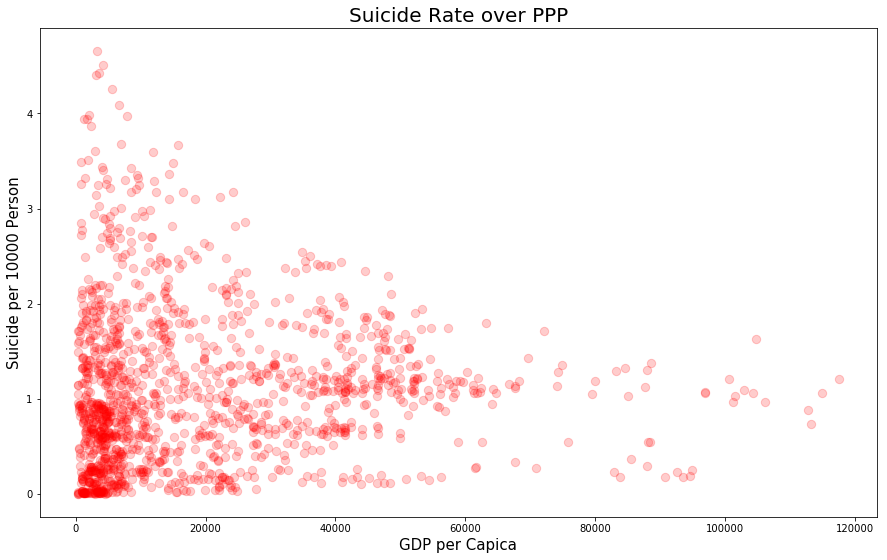

In [186]:
fig, ax = plt.subplots(figsize = (15,9))
suicide_count.plot.scatter(ax = ax, x = 'PPP', y = "SuicideRate", s = 70, c = 'red', alpha = 0.2)
plt.title("Suicide Rate over PPP", size = 20)
plt.xlabel("GDP per Capica (USD)", size = 15)
plt.ylabel("Suicide per 10000 Person", size = 15)

plt.show()

On the first look at this graph, there seems to be a decreasing relationship between PPP and suicide rate, that the countries with higher PPP has lower suicide rate. Hoever, if we look carefully at the shape and distribution, we will realize that most of the points are distributed on the left side of the plot. We believe that make the x-axis log scale would be more appropriet. Also, to reduce the effect from other factors, we would like to compare PPP and suicide rate base on other factors such as time.

The following code will generate a plot with both mean suicide rate and mean PPP across countries over time. Thus we can see if they follow a similar pattern. In addition, we shaded out an area to indicate the standard deviation of suicide rate over time.

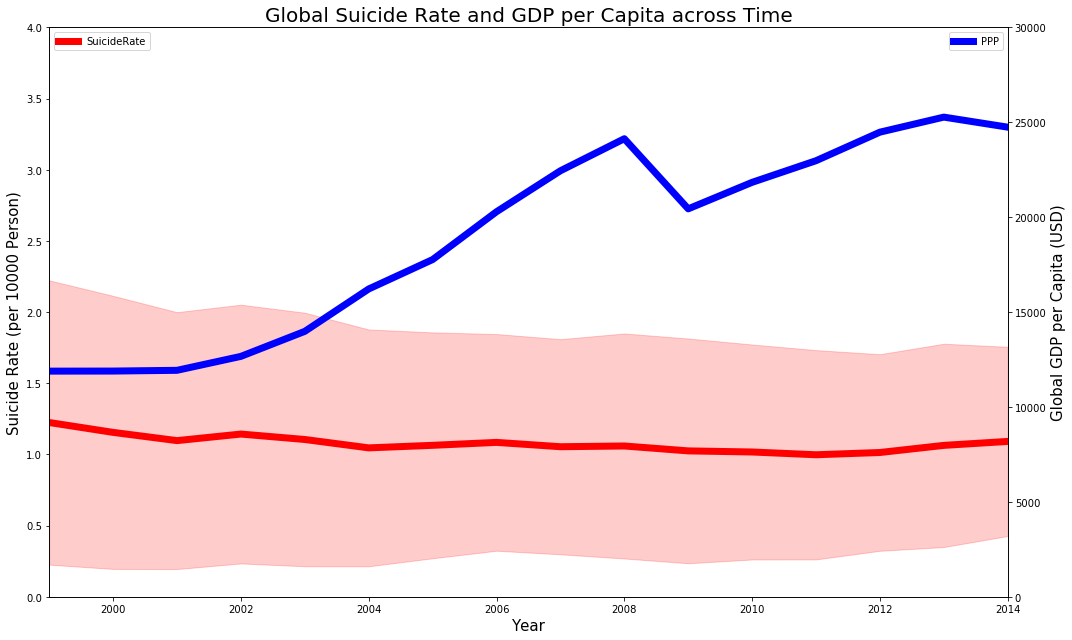

In [136]:
data_yearly_mean = suicide_count.groupby("Year").mean()
data_yearly_std = suicide_count.groupby("Year").std()

# create a chart contains plots with different scales
fig, ax1 = plt.subplots(figsize = (15,9))
ax2 = ax1.twinx()
data_yearly_mean.plot(ax = ax1, y = "SuicideRate", c = 'red', linewidth = 7)
ax1.fill_between(data_yearly_std.index, 
                 data_yearly_mean['SuicideRate'] - data_yearly_std['SuicideRate'], 
                 data_yearly_mean['SuicideRate'] + data_yearly_std['SuicideRate'], 
                 color = 'red', alpha = 0.2)
data_yearly_mean.plot(ax = ax2, y = "PPP", c = 'blue', linewidth = 7)
plt.title("Global Suicide Rate and GDP per Capita across Time", size = 20)
ax1.set_ylim(0,4)
ax2.set_ylim(0,30000)
ax1.set_xlabel("Year", size = 15)
ax2.set_xlabel("Year", size = 15)
ax1.set_ylabel("Suicide Rate (per 10000 Person)", size = 15)
ax2.set_ylabel("Global GDP per Capita (USD)", size = 15)
ax1.legend(loc=2)
fig.tight_layout()

plt.show()

From this chart we can see that the mean PPP (blue line) is generally increasing over time except a dramatic drop at 2009 due to the global financial crisis. On the other hand, the mean suicide rate (red line) does not change much over time, not even effected by the financial crisis in 2009. This means the suicide rate is not related to the global growth in economy. Therefore, in addition to using log scale, we also need to standardize the PPP by calculating the z-score of log-PPP for each year. The z-score formula is descriped as follows: 

$$ z_i=\frac{x_i-\bar{x}} s $$

In [137]:
suicide_count['logPPP'] = np.log(suicide_count['PPP'])
mean_table = suicide_count.groupby('Year').mean()
std_table = suicide_count.groupby('Year').std()
stdPPP = []
for idx, row in suicide_count.iterrows():
    stdPPP += [(row['logPPP'] - mean_table['logPPP'][row['Year']]) / std_table['logPPP'][row['Year']]]
suicide_count['stdPPP'] = stdPPP

Now let's make the plot again using standardized PPP as the horizontal axis. Hope it will show the patern we expected, that the hight PPP a country has, the lower its suicide rate. 

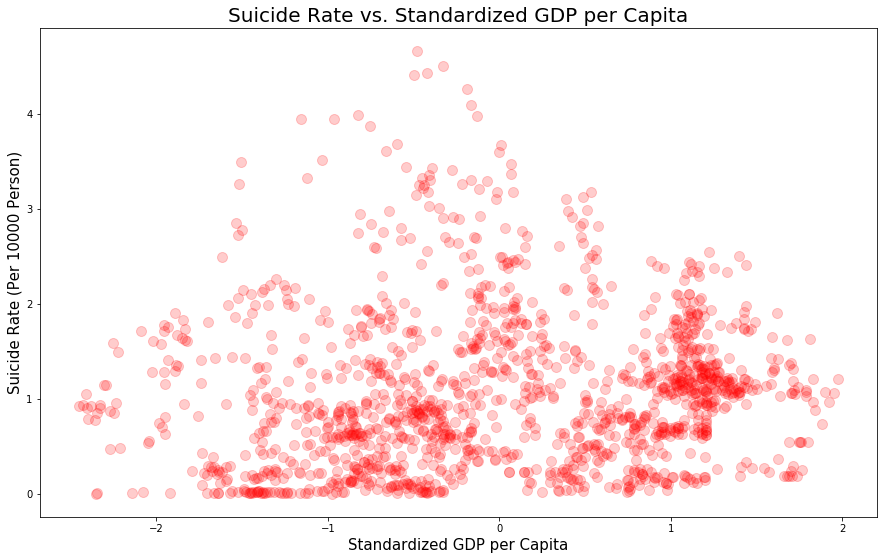

In [138]:
plt.subplots(figsize = (15,9))
plt.scatter(x = suicide_count["stdPPP"], y = suicide_count["SuicideRate"], s = 100, c = 'red', alpha = 0.2)
plt.title("Suicide Rate vs. Standardized GDP per Capita", size = 20)
plt.xlabel("Standardized GDP per Capita", size = 15)
plt.ylabel("Suicide Rate (Per 10000 Person)", size = 15)
plt.show()

Unfortunately the graph doesn't seem as expected. It looks like the relation between suicide rate and economy is not linear. The points on the left and right are mostly below 2, while many points in the middle lies above 2 and even reach up to 4. This indicates when a country has extremely high or extremely low GDP per capita compare to other countries, its suicide rate won't be high. But with medium GDP per capita, the suicide rate can be higher. 

### Fitting a Linear Regression Modle <a class="anchor" id="fit"></a>

Even though the graph does not shown as expected, I will still try to fit a linear moddle to the data to see how well it fit, and as a tutorial for using the linear modle in sklearn library. 

The table we currently have contains multiple datapoints for each country representing data from different year. But some of the countries have more data points while others have fewer, fitting a regression directly will lead to a bias result that trend toward the points of countries that have more datapoints. To avoid this bias, we need to use only one point for each country, and I decided to use the averaged standard PPP and averaged suicide rate across time. 

The next plot I'm going to make is a scatter plot between standard PPP and suicide rate, but I also want to use different color to reprecent different continent and see how datapoints of countries from each continent distribute. Plus, I'll make the point size proportional to the total number of suicide case the country has per year.

I will start by forming a new table

In [139]:
# this file contains the country name and the continent it belongs to
country2continent = pd.read_csv("Countries-Continents-csv.csv", index_col = 1)["Continent"].to_dict()
# assign each continent with unique color
continent_color = {'Africa': 'blue', 'Asia': 'orange', 'Europe': 'red', 'North America': 'green', 'Oceania':'black', 'South America': 'purple'}

suicide_count_country = suicide_count.groupby('CountryName').sum()[['Deaths1', 'TotalPopulation']]
suicide_count_country['SuicidePerYear'] = suicide_count.groupby('CountryName').mean()['Deaths1']
suicide_count_country['SuicideRate'] = suicide_count_country['Deaths1'] / suicide_count_country['TotalPopulation'] * 10000
suicide_count_country['stdPPP'] = suicide_count.groupby('CountryName').mean()['stdPPP']
suicide_count_country['Continent'] = [country2continent[country] if country in country2continent.keys() else np.nan  for country in suicide_count_country.index]
suicide_count_country.reset_index(level = ['Country'], inplace = True)
suicide_count_country['CountryCode'] = [country_name2iso[c] if c in country_name2iso.keys() else np.nan for c in suicide_count_country['CountryName']]

To fit a linear regression moddle, we simple use LinearRegression() function from sklearn, and fit() to stdPPP and suicide rate from the new table. Finally use predict() to calculate expected values. 

In [140]:
lr = LinearRegression()
sample_size = len(suicide_count_country)
xs = suicide_count_country["stdPPP"].values.reshape(sample_size,1)
ys = suicide_count_country["SuicideRate"].values.reshape(sample_size,1)
lr.fit(xs,ys)
pred_ys = lr.predict([[-2.5],[2]])

Now we make the plot discribed as above, with a regression line going through the scatter plot.

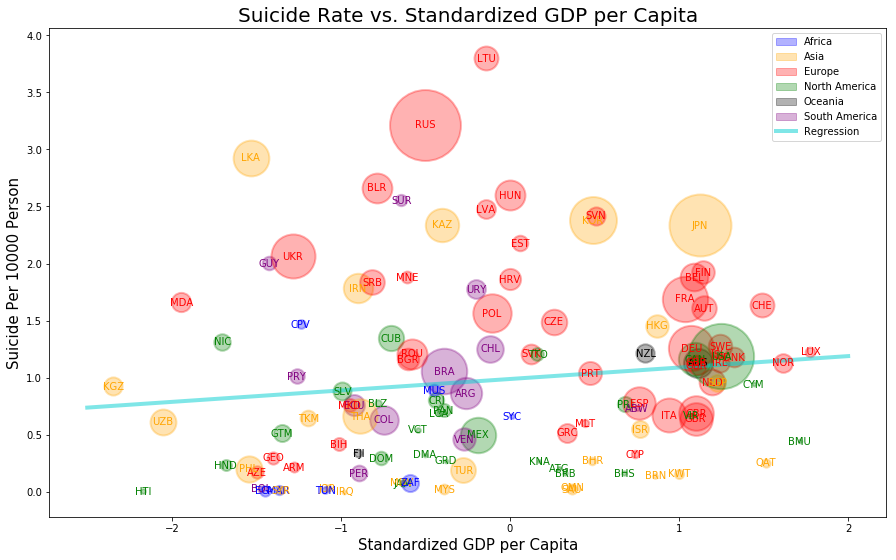

In [141]:
fig, ax = plt.subplots(figsize = (15,9))
plt.plot([[-2.5],[2]], pred_ys, color = 'DARKTURQUOISE', alpha = 0.5, linewidth = 4)
for idx, row in suicide_count_country.iterrows():
    plt.scatter(x = row["stdPPP"], y = row["SuicideRate"], lw = 2, color = continent_color[row['Continent']], alpha=0.3, s = np.sqrt(row['SuicidePerYear'])**1.2*8)
    ax.annotate(row["CountryCode"], (row["stdPPP"],row["SuicideRate"]), va="center", ha="center", color = continent_color[row['Continent']])
plt.title("Suicide Rate vs. Standardized GDP per Capita", fontsize=20)
plt.xlabel("Standardized GDP per Capita", fontsize=15)
plt.ylabel("Suicide Per 10000 Person", fontsize=15)
plt.legend(handles=[mpatches.Patch(color=color, alpha = 0.3, label=continent) for continent, color in continent_color.items()]+[mlines.Line2D([], [], linewidth = 4, color='DARKTURQUOISE', alpha = 0.5, label='Regression')])
plt.show()

Based on the graph, we see the regression has a positive slope, and we performed an F-test on our linear model. 

In [142]:
f_test = ols('SuicideRate ~ stdPPP', data = suicide_count_country).fit()
print("F-test on linear model:\n", sm.stats.anova_lm(f_test, typ = 2))

F-test on linear model:
              sum_sq     df         F    PR(>F)
stdPPP     1.218554    1.0  1.951315  0.165067
Residual  73.688483  118.0       NaN       NaN


The test has p-value of 0.165, which is quite large, it is greater than the critical value $\alpha = 0.05$, thus we conclude that linear regression is not the appropriate model for the data.

### Analyze using map <a class="anchor" id="map"></a>

Next, we will use folium library to demostrate how you can use map as a tool to display data. We use choropleth function from folium library, A [json file](https://github.com/johan/world.geo.json/blob/master/countries.geo.json) that contains the shape of each country will be needed, and we set other parameters to proper value. With fill_color set to 'YlGnBu', and threshold_scale from 0 to 4, we color each country by its suicide rate. From green to blue, countries has low to high suicide rate. And yellow indicate no data available for that country. 

In [143]:
map = folium.Map(location=[35,0], zoom_start = 2, tiles='cartodbpositron')
map.choropleth(geo_path="countries.geo.json", data = suicide_count_country, key_on = 'id',
               columns = ['CountryCode', 'SuicideRate'], threshold_scale = [0,0.0001,1,2,3,4],
               fill_color = 'YlGnBu', fill_opacity = 0.7, line_opacity = 0.5,
               legend_name = 'Suicide Rate (per 10k people)', reset = True)
map

From the map, we see that lots of countries from Africa and Asia do not have suicide data available. The missing part of the data could make a difference on the result.

### Anylyze using correlation coefficient <a class="anchor" id="r"></a>
What if we don't compare between countries, but countries compare to them self at different time? To find out, we make plots for each country showing the suicide rate vs. PPP in log scale. In addition, I colored points red to blue indicating time from earlier year to later year. On each plot, I fitted a linear regression.

D:\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


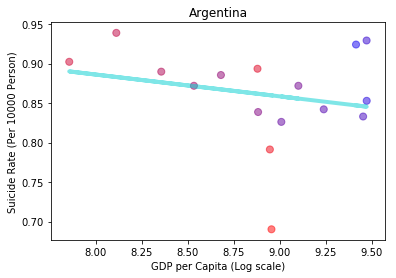

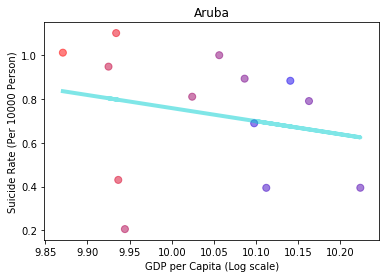

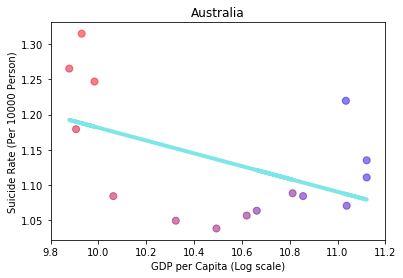

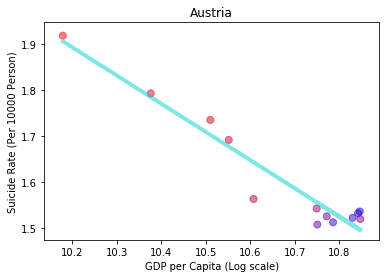

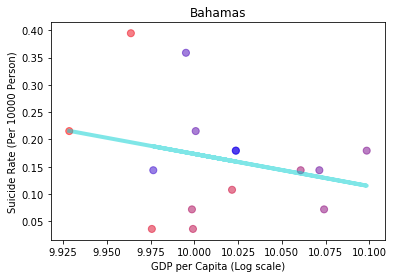

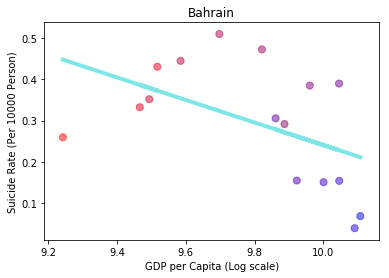

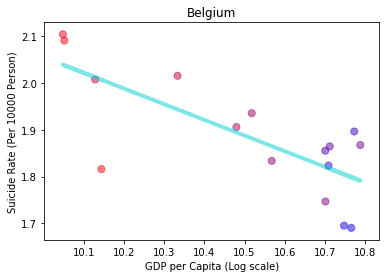

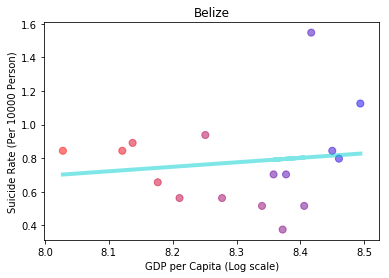

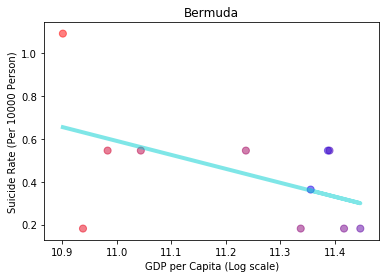

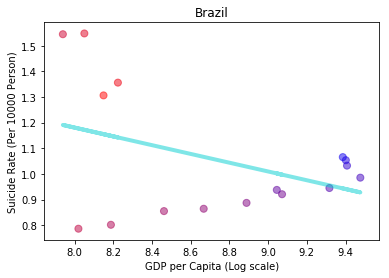

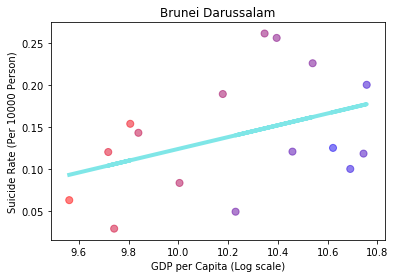

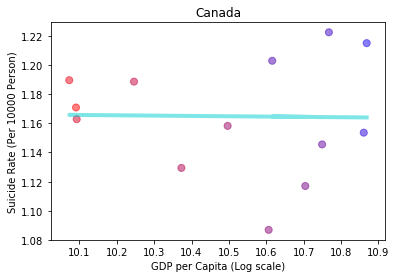

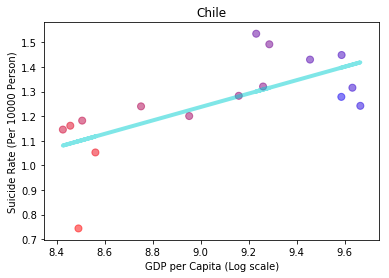

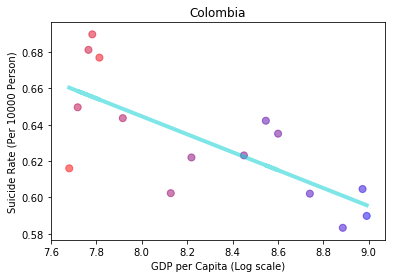

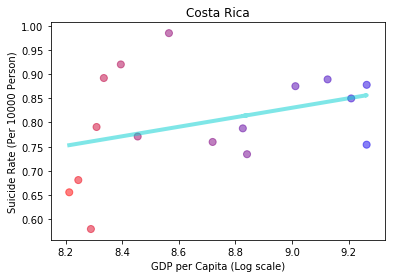

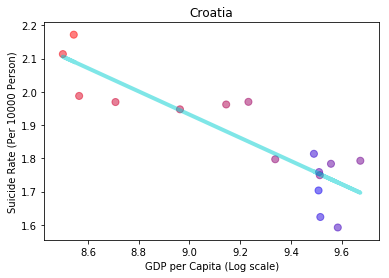

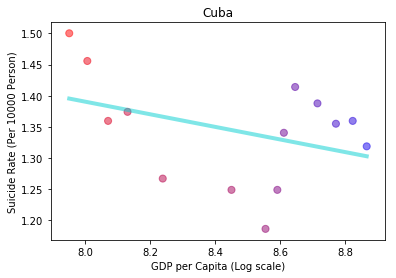

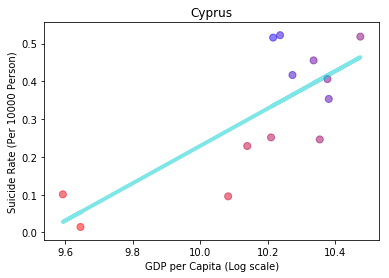

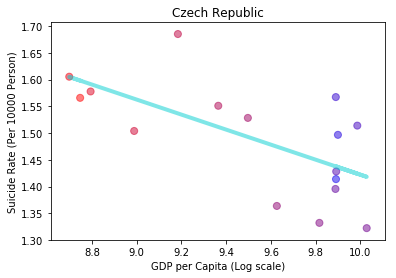

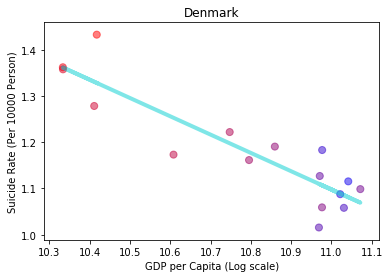

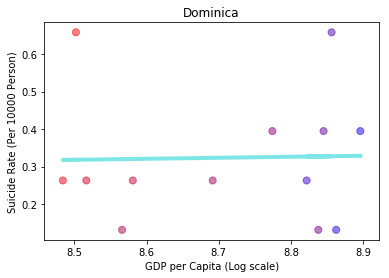

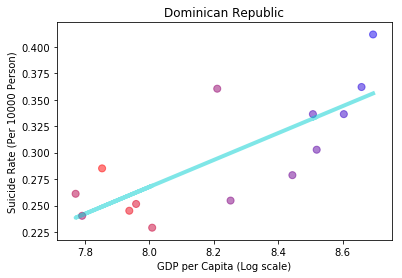

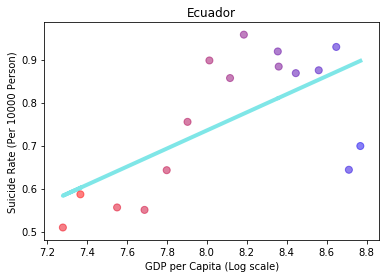

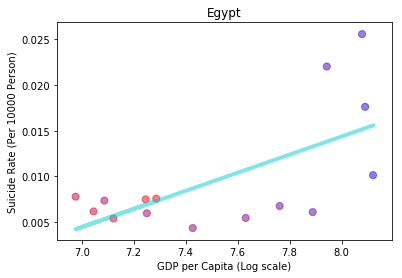

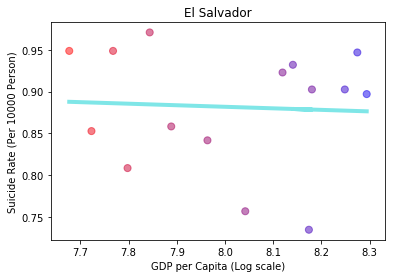

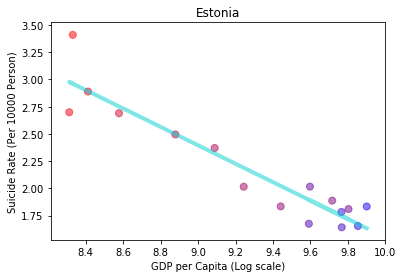

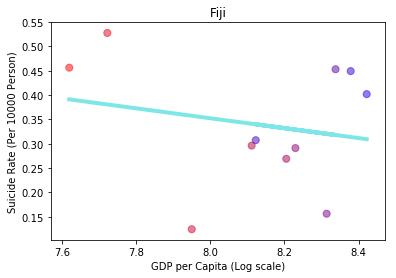

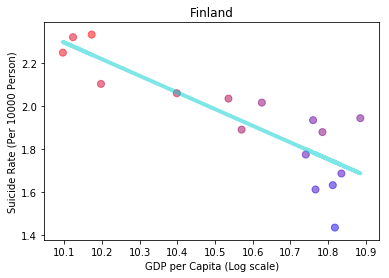

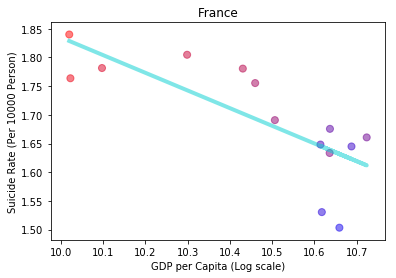

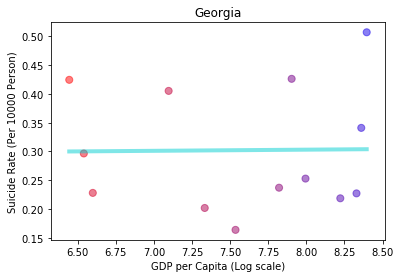

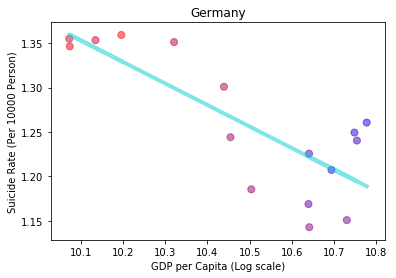

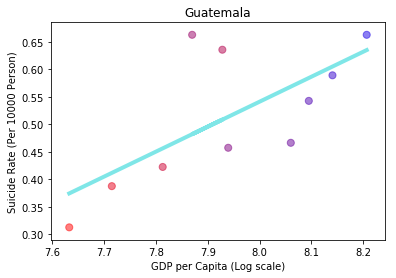

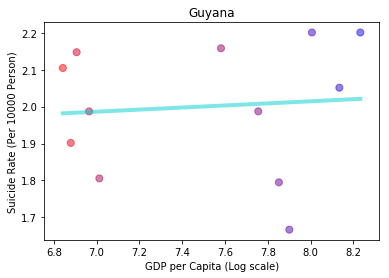

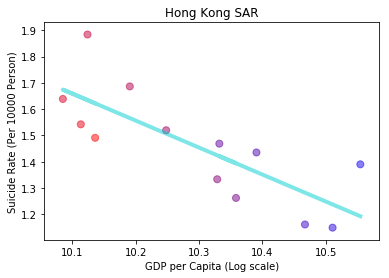

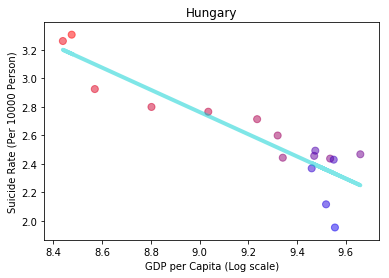

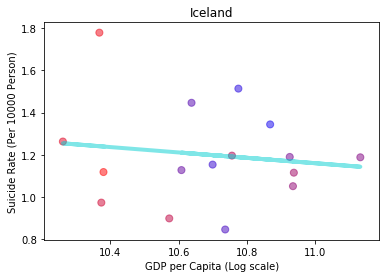

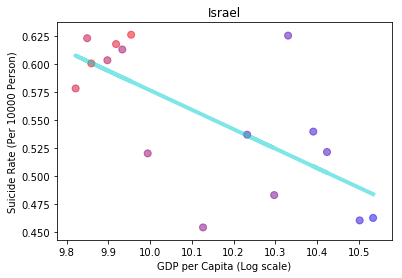

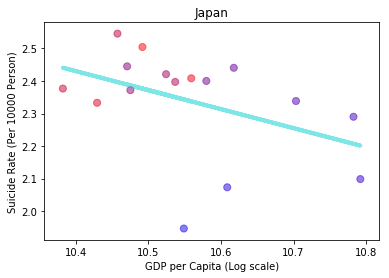

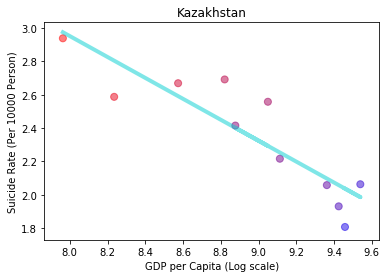

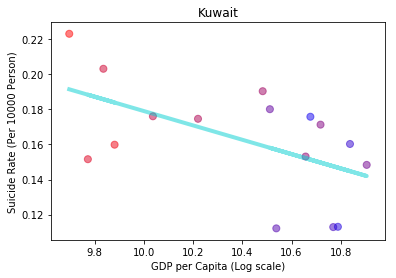

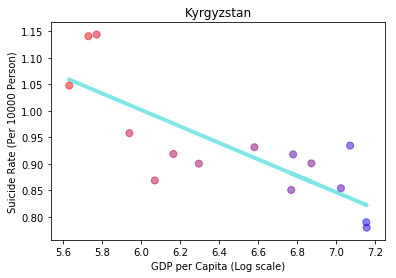

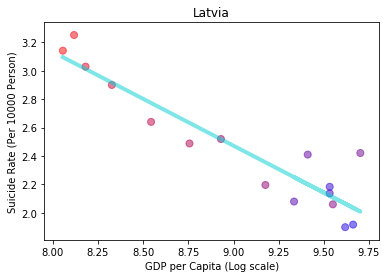

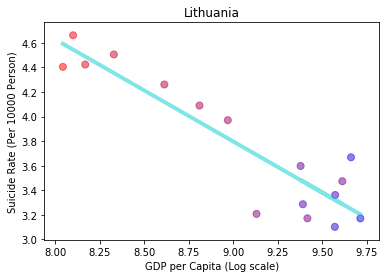

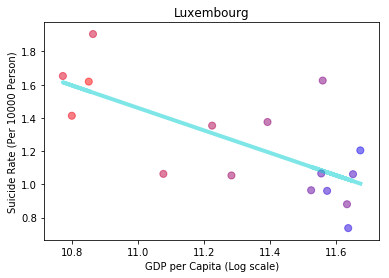

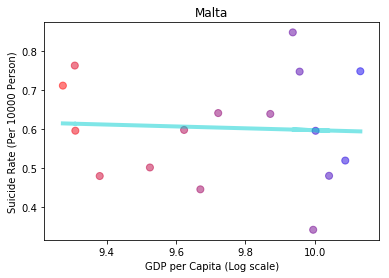

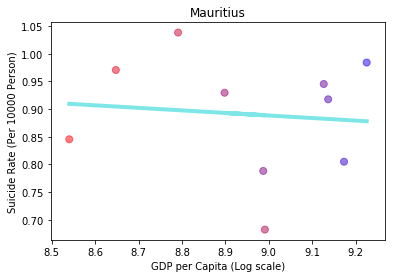

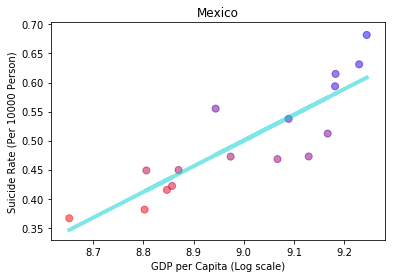

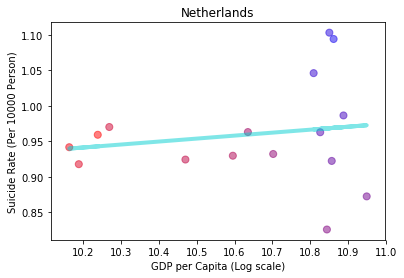

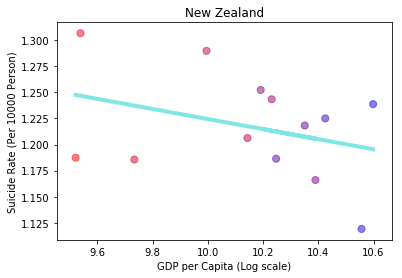

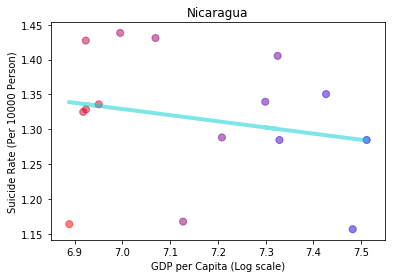

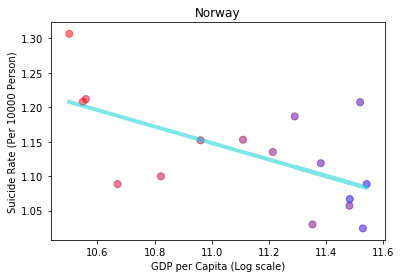

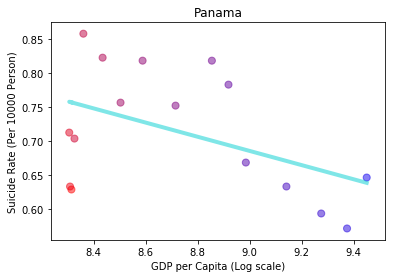

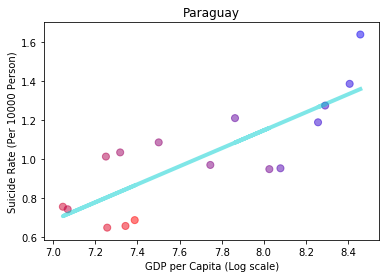

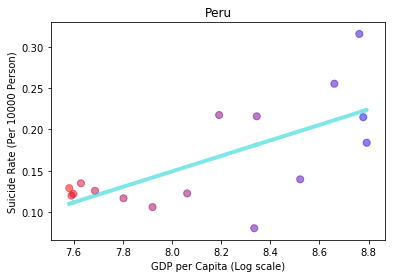

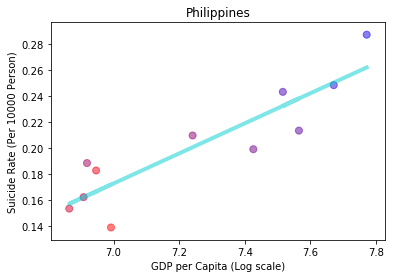

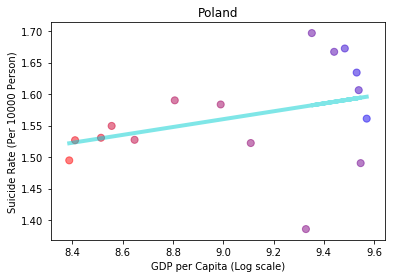

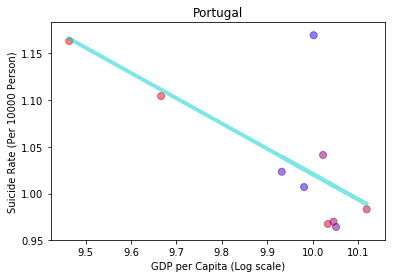

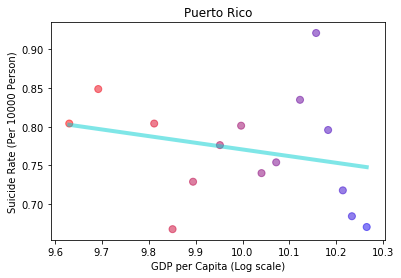

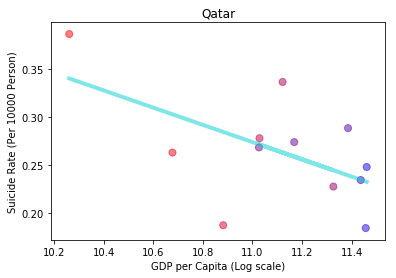

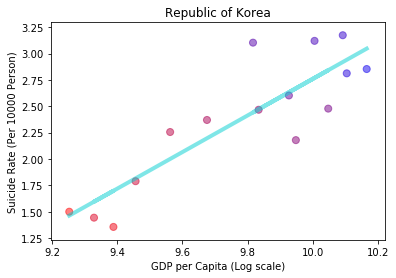

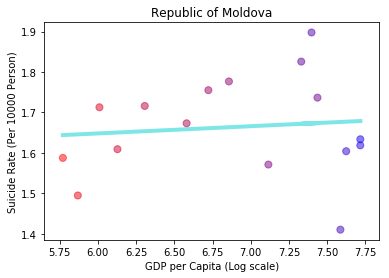

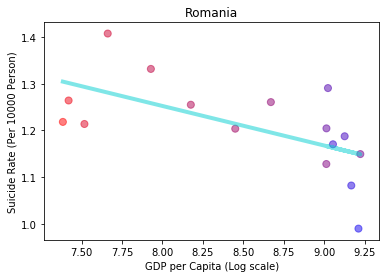

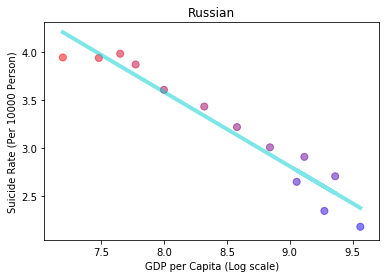

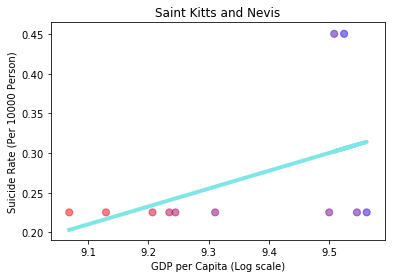

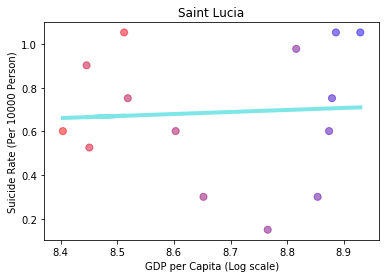

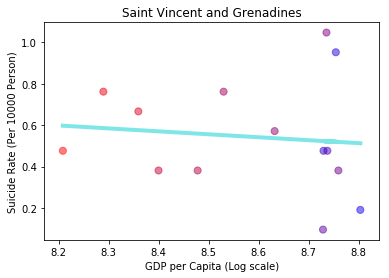

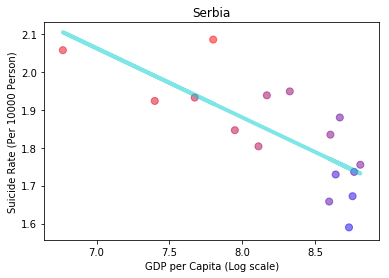

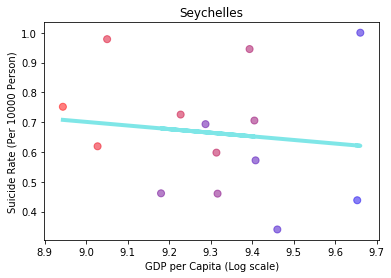

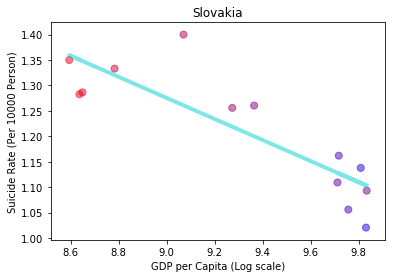

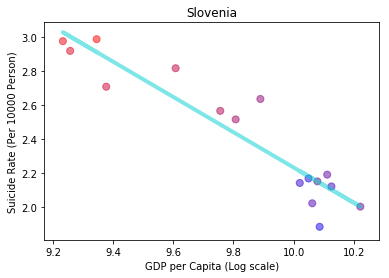

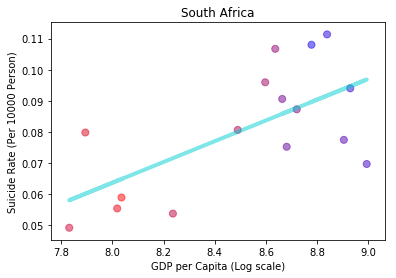

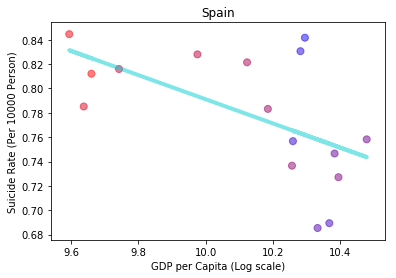

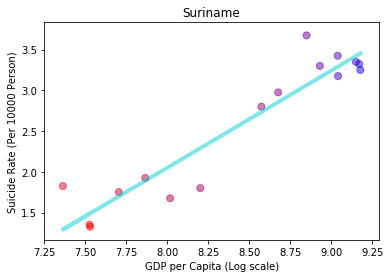

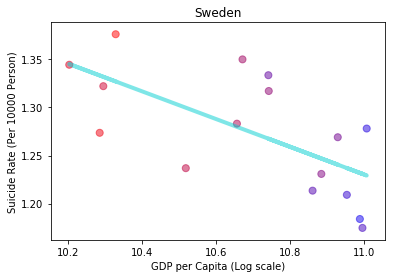

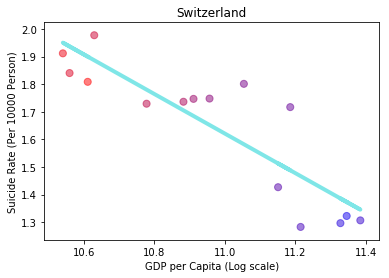

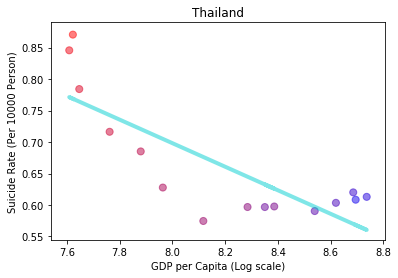

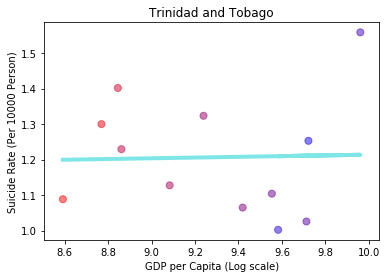

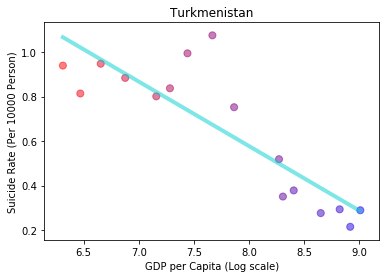

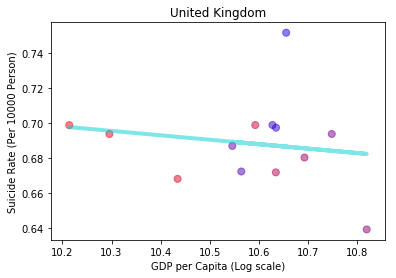

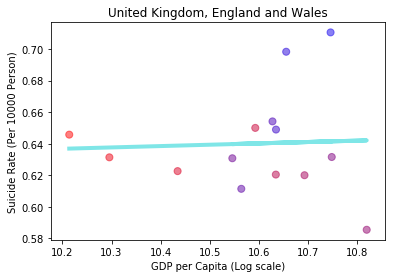

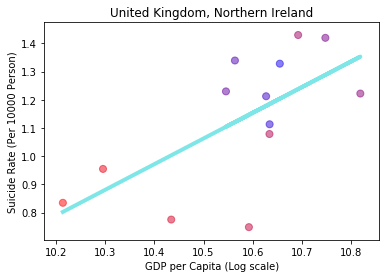

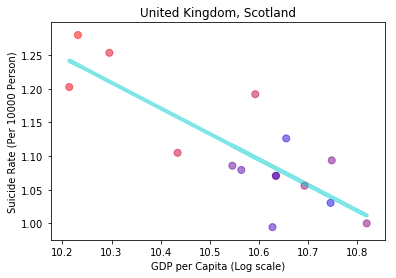

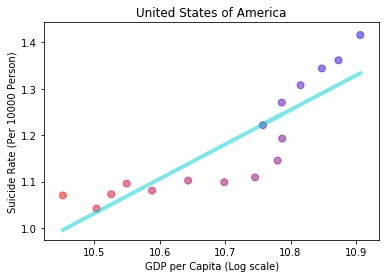

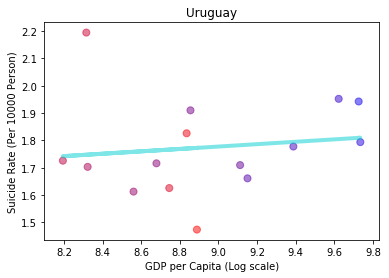

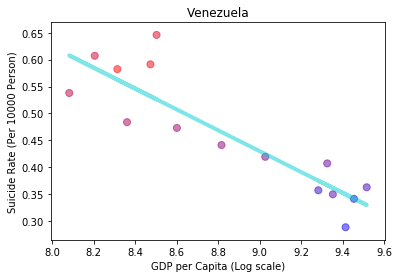

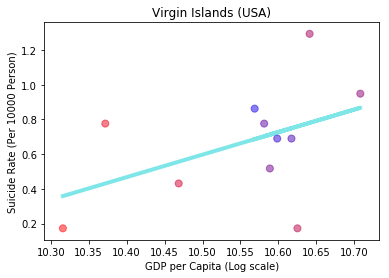

In [187]:
# filter out the countries that has less than 10 datapoints
suicide_count_year = suicide_count.groupby('CountryName').filter(lambda x: len(x) >= 10).groupby('CountryName')
for country, group in suicide_count_year:
    fig, ax = plt.subplots()
    sample_size = len(group)
    xs = group["logPPP"].values.reshape(sample_size,1)
    ys = group["SuicideRate"].values.reshape(sample_size,1)
    lr.fit(xs,ys)
    pred_ys = lr.predict(xs)
    plt.plot(xs, pred_ys, color = 'DARKTURQUOISE', alpha = 0.5, linewidth = 4)
    group.plot.scatter(ax = ax, x = 'logPPP', y = 'SuicideRate', title = country, s = 50, c = [(1-x,0,x,0.5) for x in np.arange(0,1,1/len(group))])
    plt.xlabel("GDP per Capita (Log scale)")
    plt.ylabel("Suicide Rate (Per 10000 Person)")
plt.show()

Among these plots, some of them show interesting pattern, with either positively proportional relationship (e.g. USA) or negatively proportional relationship (e.g. Russian). And others do not show a strong correlation. We then calculate the correlation coefficient $r$ for each country using pearsonr function from SciPy.

In [189]:
r_table = []
for country, group in suicide_count_year:
    (r, p) = pearsonr(group['logPPP'], group['SuicideRate'])
    r_table += [[group['CountryCode'].values[0], r]]
r_df = pd.DataFrame(r_table, columns = ['CountryCode', 'r'])

Again, we display The correlation coefficient on the map, and use three colors to indicate negative correlation, no strong correlation, and positive correlation. 

In [190]:
map = folium.Map(location=[35,0], zoom_start = 2, tiles='cartodbpositron')
map.choropleth(geo_path="countries.geo.json", data = r_df, key_on = 'id',
               columns = ['CountryCode', 'r'], threshold_scale = [-1,-0.8,-0.8,0.8,0.8,1],
               fill_color = 'YlGnBu', fill_opacity = 0.7, line_opacity = 0.5,
               legend_name = 'Suicide Rate (per 10k people)', reset = True)
map

From the map we see that most of the countries has no strong correlation coefficient while many in Asia and Europe countries have negative correlation, and only a few countries has positive correlation coefficient. 

For most of the countries, the PPP is increasing over time. The correlation between suicide rate and PPP might be caused by correlation between suicide rate and time. To test this, we make a similar map, but use time instead of PPP. 

In [108]:
r_table = []
for country, group in suicide_count_year:
    (r, p) = pearsonr(group['Year'], group['SuicideRate'])
    r_table += [[group['CountryCode'].values[0], r]]
r_df = pd.DataFrame(r_table, columns = ['CountryCode', 'r'])

In [152]:
map = folium.Map(location=[35,0], zoom_start = 2, tiles='cartodbpositron')
map.choropleth(geo_path="countries.geo.json", data = r_df, key_on = 'id',
               columns = ['CountryCode', 'r'], threshold_scale = [-1,-0.8,-0.8,0.8,0.8,1],
               fill_color = 'YlGnBu', fill_opacity = 0.7, line_opacity = 0.5,
               legend_name = 'Suicide Rate (per 10k people)', reset = True)
map

We see the map is nearly identical to the one shown previously. That means the correlation between suicide rate and PPP may be caused by time

Now, instead of use PPP, we calulate the correlation coefficient between suicide rate and standardized PPP, which is not always increasing over time. Thus we can see if a nation's economy really affect its suicide rate.

In [173]:
r_table = []
for country, group in suicide_count_year:
    (r, p) = pearsonr(group['stdPPP'], group['SuicideRate'])
    r_table += [r]
r_table = np.array(r_table)

Most of the correlations are close to zero, not sufficient to indicate a linear relation. But we can count the number of positive correlations and number of negative correlations. If there is no correlation indeed, theses number should be similar.

In [180]:
r_neg = len(r_table[r_table < 0])
r_pos = len(r_table) - r_neg
print("number of negative r:", r_neg)
print("number of positive r:", r_pos)

number of negative r: 57
number of positive r: 29


We see that the number of negative correlation is much more than the number of positive correlation. We might say there is a week relation between PPP and suicide rate. That when a country's economy grows more than other countries, its cuicide rate tend to decrease. 